# FX Value strategy


## Model to determine Fair value

Assume we use 100 USD to buy GBP with the exchange rate $FX_1$ (GBP/USD). This yields $100FX_1$ GBP.

With this $100FX_1$ GBP we invest in the UK market at a return $r_{UK}$. This yields $100FX_1(1+r_{UK})$ GBP at the end of the period.

If instead, we invest the original 100 USD in the US market, we will get $100(1+r_{US})$ USD at the end of the period.

Now if we use this amount of USD to buy GBP with exchange rate $FX_2$ (GBP/USD), we will have $100FX_2(1+r_{US})$ GBP.

Assumming equilibrium, the two amount should be the same; otherwise investors will make use of the rate differences to earn profit. In other words,

$$FX_1 (1+r_{UK}) = FX_2 (1+r_{US})$$

And we can get:

$$FX_2 = FX_1 \frac{1+r_{UK}}{1+r_{US}}$$

This will be our model to estimate the Fair value of current exchange rate $FX_2$

## Approach to obtain required variables

The market return for each country is computed by finding the percentage change of its Stock market index over a chosen period. We choose 1 month for our strategy.

The past exchange rate $FX_1$ is found by computing the rolling average of spot exchange rate, one period before the current exchange rate. It is the same period as above, 1 month.

## Strategy

If **spot exchange rate < estimated fair value**, we **buy now** and enter a forward contract to **sell in the future** (long position)

If **spot exchange rate > estimated fair value**, we **sell now** and enter a forward contract to **buy in the future** (short position)

All forward contracts are for delivery in **1 month**.

Note that we have a _threshold_ to decide whether we will proceed with entering the future contract. The purpose of this threshold is to reject insignificant deviations from the fair value.

## Limitation

Due to limited resources and time constraint, we only test our strategy against GBP/USD exchange rate.

## Set up
Import packages and define helper functions

In [0]:
# Import necessary packages
import pandas as pd
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
import requests
import json

%matplotlib inline
plt.style.use('seaborn')

In [0]:
# Define a function to query data

def get_data_request(url, access_token, requestData):
    '''make HTTP GET request'''
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    
    if dResp.status_code != 200:
        print("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        return jResp

In [0]:
# Define a function to retrieve data from Refinitiv Data Science Accelerator
# Default window time period is from 2016-11-01 to 2018-01-01

def query_refinitiv_data(ric,start_date='2016-11-01',end_date='2018-01-01'):
  access_token = '123456789'  # your personal key for Data Science Accelerator access to Pricing Data
  RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ric

  requestData = {
      "interval": "P1D",
      "start": start_date,
      "end": end_date,
      "fields": 'TRDPRC_1' #BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS
  };

  # Get the data from Refinitiv server
  jResp = get_data_request(RESOURCE_ENDPOINT, access_token, requestData)

  # Create a DataFrame from the retrieved data
  if jResp is not None:
      data = jResp[0]['data']
      headers = jResp[0]['headers']  
      names = [headers[x]['name'] for x in range(len(headers))]
      df = pd.DataFrame(data, columns=names )

      # Make DATE into DateTime object and make it the Index of df
      df.DATE = pd.to_datetime(df.DATE)
      df = df.set_index('DATE')

      df = df.rename(columns={'TRDPRC_1': 'Price'})
      df = df.sort_index()
      
      return df

## Query spot FX data

In [4]:
# Query spot FX data and create a DataFrame from the data
GBP_USD_df = query_refinitiv_data('=GBP')
GBP_USD_df = GBP_USD_df.rename(columns={'Price':'GBP/USD'})
GBP_USD_df.tail()

Data access successful


,GBP/USD
DATE,
2017-12-26,78.1
2017-12-27,78.0
2017-12-28,78.0
2017-12-29,78.2
2018-01-01,78.2


Text(0, 0.5, 'Price')

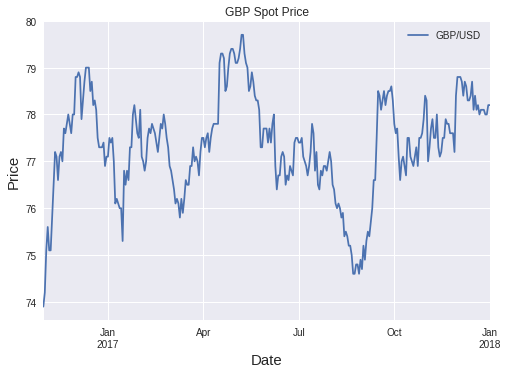

In [5]:
GBP_USD_df.plot(title= 'GBP Spot Price')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)

## Query Stock market indices

We choose the following Stock market index for US and UK

Country|Index
-------|---
US     |SPX
GBP     |FTSE

In [6]:
SPX_df = query_refinitiv_data('.SPX')
SPX_df = SPX_df.rename(columns={'Price': 'SPX'})
SPX_df.tail()

Data access successful


,SPX
DATE,
2017-12-22,2683.34
2017-12-26,2680.50
2017-12-27,2682.62
2017-12-28,2687.54
2017-12-29,2673.61


In [7]:
FTSE_df = query_refinitiv_data('.FTSE')
FTSE_df = FTSE_df.rename(columns={'Price': 'FTSE'})
FTSE_df.tail()

Data access successful


,FTSE
DATE,
2017-12-21,7603.98
2017-12-22,7592.66
2017-12-27,7620.68
2017-12-28,7622.88
2017-12-29,7687.77


## Prepare data for GBP/USD

Combine GBP/USD, SPX and FTSE into 1 DataFrame

In [8]:
GBP_USD_df = pd.merge(GBP_USD_df,SPX_df,how='outer',left_index=True,right_index=True)
GBP_USD_df = pd.merge(GBP_USD_df,FTSE_df,how='outer',left_index=True,right_index=True)
GBP_USD_df.fillna(method='ffill',inplace=True)
GBP_USD_df.tail()

,GBP/USD,SPX,FTSE
DATE,,,
2017-12-26,78.1,2680.50,7592.66
2017-12-27,78.0,2682.62,7620.68
2017-12-28,78.0,2687.54,7622.88
2017-12-29,78.2,2673.61,7687.77
2018-01-01,78.2,2673.61,7687.77


Calculate moving average of the indices, which provide a better estimate for the Intrinsic value of those indices

In [9]:
GBP_USD_df['GBP/USD 5D'] = GBP_USD_df['GBP/USD'].rolling(5).mean()
GBP_USD_df['SPX MA 5D'] = GBP_USD_df['SPX'].rolling(5).mean()
GBP_USD_df['FTSE MA 5D'] = GBP_USD_df['FTSE'].rolling(5).mean()
GBP_USD_df.tail()

,GBP/USD,SPX,FTSE,GBP/USD 5D,SPX MA 5D,FTSE MA 5D
DATE,,,,,,
2017-12-26,78.1,2680.50,7592.66,78.10,2682.200,7581.436
2017-12-27,78.0,2682.62,7620.68,78.06,2682.874,7600.528
2017-12-28,78.0,2687.54,7622.88,78.06,2683.468,7604.308
2017-12-29,78.2,2673.61,7687.77,78.08,2681.522,7623.330
2018-01-01,78.2,2673.61,7687.77,78.10,2679.576,7642.352


Plot for visualization

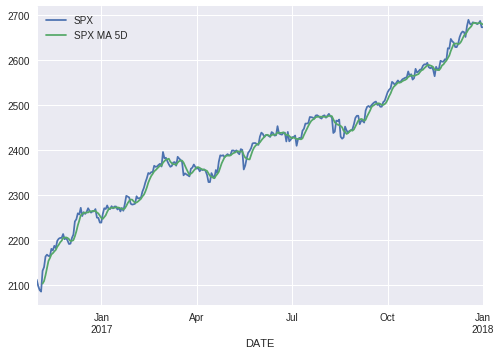

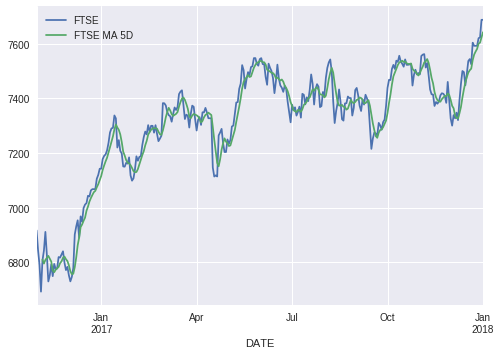

In [10]:
GBP_USD_df.loc[:,['SPX','SPX MA 5D']].plot()
GBP_USD_df.loc[:,['FTSE','FTSE MA 5D']].plot()

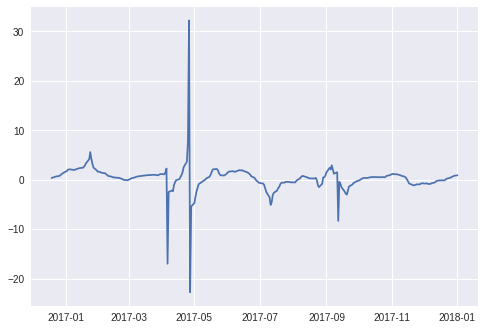

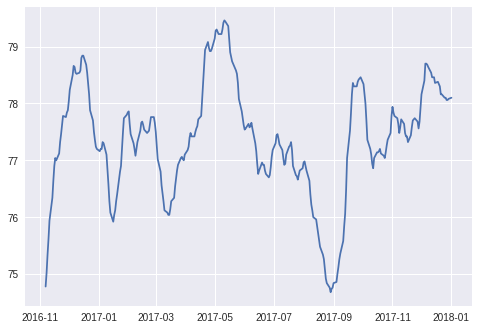

In [11]:
plt.plot(GBP_USD_df.index,GBP_USD_df['FTSE MA 5D'].pct_change(30)/GBP_USD_df['SPX MA 5D'].pct_change(30))
plt.figure()
plt.plot(GBP_USD_df.index,GBP_USD_df['GBP/USD 5D'])

## Calculating market return for 1 period

There are on average 30 days of in a month. We take 30 days to be our period duration for calculation

In [0]:
duration = 30

In [13]:
GBP_USD_df['SPX Returns 1M'] = GBP_USD_df['SPX MA 5D'].pct_change(duration)
GBP_USD_df['FTSE Returns 1M'] = GBP_USD_df['FTSE MA 5D'].pct_change(duration)
GBP_USD_df.tail()

,GBP/USD,SPX,FTSE,GBP/USD 5D,SPX MA 5D,FTSE MA 5D,SPX Returns 1M,FTSE Returns 1M
DATE,,,,,,,,
2017-12-26,78.1,2680.50,7592.66,78.10,2682.200,7581.436,0.037601,0.016921
2017-12-27,78.0,2682.62,7620.68,78.06,2682.874,7600.528,0.040257,0.023797
2017-12-28,78.0,2687.54,7622.88,78.06,2683.468,7604.308,0.040405,0.026995
2017-12-29,78.2,2673.61,7687.77,78.08,2681.522,7623.330,0.039928,0.031020
2018-01-01,78.2,2673.61,7687.77,78.10,2679.576,7642.352,0.039391,0.034313


In [14]:
GBP_USD_df.reset_index(inplace=True)
GBP_USD_df.tail()

,DATE,GBP/USD,SPX,FTSE,GBP/USD 5D,SPX MA 5D,FTSE MA 5D,SPX Returns 1M,FTSE Returns 1M
300,2017-12-26,78.1,2680.50,7592.66,78.10,2682.200,7581.436,0.037601,0.016921
301,2017-12-27,78.0,2682.62,7620.68,78.06,2682.874,7600.528,0.040257,0.023797
302,2017-12-28,78.0,2687.54,7622.88,78.06,2683.468,7604.308,0.040405,0.026995
303,2017-12-29,78.2,2673.61,7687.77,78.08,2681.522,7623.330,0.039928,0.031020
304,2018-01-01,78.2,2673.61,7687.77,78.10,2679.576,7642.352,0.039391,0.034313


## Calculating Fair value of exchange rate using the proposed model

$$FX_2 = FX_1 \frac{1+r_{UK}}{1+r_{US}}$$

In [0]:
GBP_USD_df['GBP/USD Fair value'] = np.nan
for i in np.arange(duration,len(GBP_USD_df)):
    GBP_USD_df.loc[i,'GBP/USD Fair value'] = GBP_USD_df.loc[i-duration,'GBP/USD 5D'] * (1 + GBP_USD_df.loc[i,'FTSE Returns 1M']) / (1 + GBP_USD_df.loc[i,'SPX Returns 1M'])

In [16]:
GBP_USD_df.tail()

,DATE,GBP/USD,SPX,FTSE,GBP/USD 5D,SPX MA 5D,FTSE MA 5D,SPX Returns 1M,FTSE Returns 1M,GBP/USD Fair value
300,2017-12-26,78.1,2680.50,7592.66,78.10,2682.200,7581.436,0.037601,0.016921,75.935828
301,2017-12-27,78.0,2682.62,7620.68,78.06,2682.874,7600.528,0.040257,0.023797,76.195030
302,2017-12-28,78.0,2687.54,7622.88,78.06,2683.468,7604.308,0.040405,0.026995,76.422113
303,2017-12-29,78.2,2673.61,7687.77,78.08,2681.522,7623.330,0.039928,0.031020,76.657679
304,2018-01-01,78.2,2673.61,7687.77,78.10,2679.576,7642.352,0.039391,0.034313,77.061606


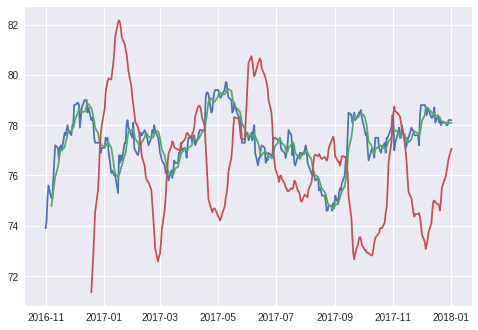

In [17]:
plt.plot(GBP_USD_df['DATE'],GBP_USD_df['GBP/USD'])
plt.plot(GBP_USD_df['DATE'],GBP_USD_df['GBP/USD 5D'])
plt.plot(GBP_USD_df['DATE'],GBP_USD_df['GBP/USD Fair value'])

## Sharpe ratio and Backtesting

Take the risk free rate to be 1.4% and constant throughout our analysis.

We enter forward contracts for delivery in 1 month time. Thus, our **realized return** will be computed using *current spot exchange rate* and *spot exchange rate in 1 month later*.

In [0]:
Ra = np.array([])
total_return = 0
threshold = 1

In [0]:
for i in np.arange(len(GBP_USD_df)-duration):
    if GBP_USD_df.loc[i,'GBP/USD'] - GBP_USD_df.loc[i,'GBP/USD Fair value'] > threshold:              # long position
        Return = 1 - GBP_USD_df.loc[i+duration,'GBP/USD'] / GBP_USD_df.loc[i,'GBP/USD']               # realized return
        Ra = np.append(Ra, Return)    
        total_return += 100 * Return
    
    elif GBP_USD_df.loc[i,'GBP/USD'] - GBP_USD_df.loc[i,'GBP/USD Fair value'] < -threshold:           # short position
        Return = GBP_USD_df.loc[i+duration,'GBP/USD'] / GBP_USD_df.loc[i,'GBP/USD'] - 1               # realized return
        Ra = np.append(Ra, Return)    
        total_return += 100 * Return

In [0]:
# convert to annual rate, compount the rate by 12 periods (there are 12 months in a year)
Ra = (Ra + 1)**12 - 1

In [21]:
Ra.mean()

0.14337656172005883

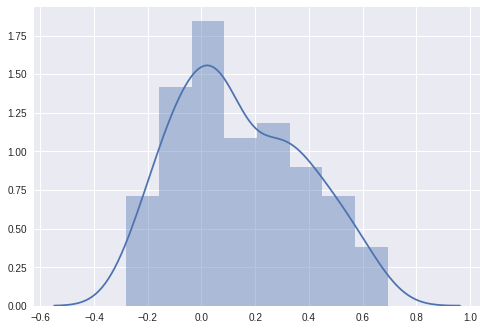

In [22]:
sns.distplot(Ra)

In [23]:
Sharpe_ratio = (Ra.mean() - 0.014) / Ra.std()
Sharpe_ratio

0.5466553040687679

In [24]:
total_return

166.58361781839017

## Export estimated Fair value

For submission purpose

In [25]:
FV_df = GBP_USD_df.loc[:,['DATE','GBP/USD Fair value']]
FV_df.tail()

,DATE,GBP/USD Fair value
300,2017-12-26,75.935828
301,2017-12-27,76.195030
302,2017-12-28,76.422113
303,2017-12-29,76.657679
304,2018-01-01,77.061606


In [0]:
FV_df.to_csv('Fair value',index=False)